#라이브러리

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2, glob, tqdm, time
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#데이터셋 설정

In [145]:
path_x = '/content/drive/MyDrive/newstudy/ocean_trash_classfication/train/images/'
path_test = '/content/drive/MyDrive/newstudy/ocean_trash_classfication/test/images/'

img_height = 224
img_width = 224

In [5]:
classes = []
for path in glob.glob(path_x+'*'):
    classes.append(path.split('/')[-1])
print(classes)

['bundle of ropes', 'circular fish trap', 'eel fish trap', 'rope', 'fish net', 'other objects', 'rectangular fish trap', 'tire', 'spring fish trap', 'wood']


In [9]:
print(classes.index('bundle of ropes'))

0


In [147]:
x_list = []

for path in glob.glob(path_x+'*'):
    x_list += glob.glob(path+'/*')

train_x,valid_x = train_test_split(x_list,test_size=0.2,random_state=1000)
test_x = sorted(glob.glob(path_test+'*'))

print(len(train_x))
print(len(valid_x))

5749
1438


In [105]:
class Custom_Dataset(Dataset):
    
    def __init__(self, x_list):
        self.x_list = x_list
        
    def __len__(self):
        return len(self.x_list)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.x_list[idx],cv2.IMREAD_COLOR)
        img = cv2.resize(img,(img_width,img_height))
        img = img / 255.0
        img = img.astype(np.float32)
        img = torch.from_numpy(img)
        img = torch.permute(img,(2,0,1))

        label = classes.index(self.x_list[idx].split('/')[-2])
        label = F.one_hot(torch.tensor(label),len(classes)).float()

        return img, label
train_set = Custom_Dataset(train_x)
val_set = Custom_Dataset(valid_x)

In [106]:
ds = iter(train_set)

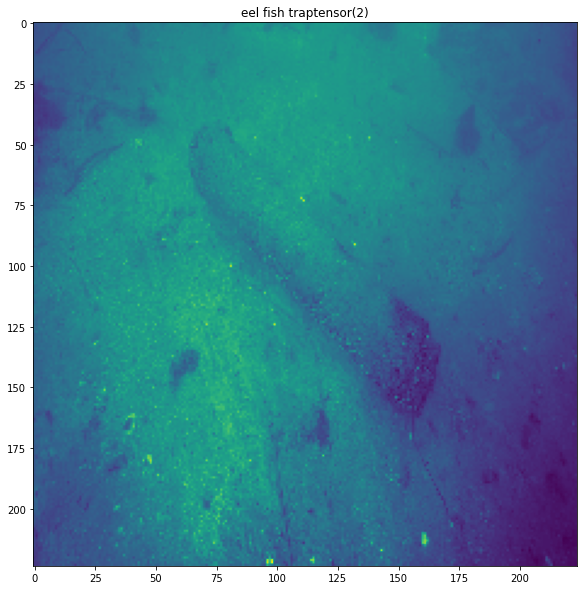

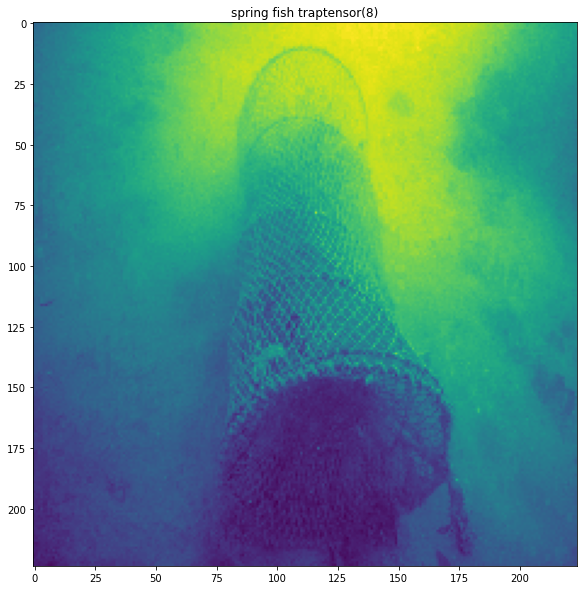

In [108]:
ds = iter(train_set)
for i in range(2):
    img, label = next(ds)
    plt.figure(figsize=(10,10))
    plt.title(classes[torch.argmax(label)]+str(torch.argmax(label)))
    plt.imshow(img[0])
    plt.show()

#모델구현

In [134]:
class bottleneck_block(nn.Module):
    def __init__(self,i,o,s,e,stage):
        super(bottleneck_block,self).__init__()
        
        self.conv1 = nn.Conv2d(i,o,1,s)
        self.bn1 = nn.BatchNorm2d(o)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(o,o,3,1,1)
        self.bn2 = nn.BatchNorm2d(o)
        self.conv3 = nn.Conv2d(o,o*e,1,1)
        self.bn3 = nn.BatchNorm2d(o*e)
        if s == 2 or i==o:
          self.identity = nn.Sequential(
              nn.Conv2d(i,o*e,1,s),
              nn.BatchNorm2d(o*e)
          )
        else :
          self.identity = nn.Sequential()
        

    def forward(self,x):
        identity = self.identity(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)

        out += identity
        out = self.relu(out)

        return out


class ResNet50(nn.Module):
    def __init__(self,e=4,num_layers=[3,4,6,3]):
        super(ResNet50,self).__init__()
        def n_blocks(i,o,s,stage):
            layers = []
            layers.append(bottleneck_block(i,o,s,e,stage))

            for _ in range(1,num_layers[stage]):
                layers.append(bottleneck_block(o*e,o,1,e,stage))

            return nn.Sequential(*layers)

        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,64,7,2,3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(3,2,1)
        )

        self.stage1 = n_blocks(64,64,1,0)
        self.stage2 = n_blocks(64*e,128,2,1)
        self.stage3 = n_blocks(128*e,256,2,2)
        self.stage4 = n_blocks(256*e,512,2,3)

        self.F = nn.AdaptiveAvgPool2d(1)

        self.FC = nn.Sequential(
            nn.Linear(512*e,len(classes)),
            nn.Softmax(1)
        )

    def forward(self,x):
        out = self.conv1(x)
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)

        out = self.F(out)

        out = out.view(out.size(0),-1)

        out = self.FC(out)
        
        return out



#학습지표 설정

In [135]:
def accuracy(pred, label):
    batch_size = len(pred)
    _,pred = torch.max(pred, dim=1)
    _,label = torch.max(label, dim=1)
    accuracy = torch.sum(pred==label)/batch_size
    return accuracy

#학습

In [138]:
model = ResNet50()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
max_lr = 1e-3
epochs = 50
optimizer = torch.optim.Adam(model.parameters(),lr=max_lr)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch)

model_save_path = './Best.pt'

batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)   

In [ ]:

train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
lrs = []
min_epoch = 0
fit_time = time.time()


for epoch in range(epochs):
    running_train_loss = 0.0
    running_valid_loss = 0.0

    running_train_acc = 0.0
    running_valid_acc = 0.0

    lrs.append(optimizer.param_groups[0]['lr'])

    progress_train = tqdm.tqdm(train_loader,desc=f'Epoch:{epoch+1}/{epochs}')
    for i,data in enumerate(progress_train):
        img,label = data
        optimizer.zero_grad()
        img = img.to(device)
        label = label.to(device)

        pred = model(img)
        
        loss = criterion(pred, label)
        
        acc = accuracy(pred,label)

        loss.backward()
        optimizer.step() 
        
        running_train_loss += loss
        running_train_acc += acc
        progress_train.set_description(f'Epoch:{epoch+1}/{epochs} | Train_Acc:{running_train_acc/(i+1):.4f} | Train_Loss:{running_train_loss/(i+1):.4f}')

    model.eval()
    test_loss = 0
    test_accuracy = 0
    val_iou_score = 0
    with torch.no_grad():
        progress_valid = tqdm.tqdm(val_loader,desc=f'Epoch:{epoch+1}/{epochs}')
        for i, data in enumerate(progress_valid):
            img.label = data
            
            img = img.to(device)
            label = label.to(device)
            
            
            pred = model(img)
            
            loss = criterion(pred, label)          
            acc = accuracy(pred,label)

            running_valid_loss += loss
            running_valid_acc += acc
            progress_valid.set_description(f'Epoch:{epoch+1}/{epochs} | Valid_Acc:{running_valid_acc/(i+1):.4f} | Valid_Loss:{running_valid_loss/(i+1):.4f}') 

    scheduler.step()
    train_losses.append((running_train_loss/len(train_loader)).detach().cpu().numpy())
    valid_losses.append((running_valid_loss/len(val_loader)).detach().cpu().numpy())
    train_accs.append((running_train_acc/len(train_loader)).detach().cpu().numpy())
    valid_accs.append((running_valid_acc/len(val_loader)).detach().cpu().numpy())

    if valid_losses[min_epoch] >= valid_losses[epoch]:
        print(f'Valid Loss가 최소가 됐습니다. ({valid_losses[min_epoch]:.4f}({min_epoch+1}) -> {valid_losses[epoch]:.4f}({epoch+1})')
        print(f'해당 모델이 {model_save_path} 경로에 저장됩니다.')
        min_epoch = epoch
        torch.save(model, model_save_path)
    else:
        print(f'Valid_Loss가 최소가 되지 못했습니다.(최소 Epoch:{min_epoch+1} : {valid_losses[min_epoch]:.4f})')
    print('')
            


    
print('학습 최종 시간: {:.2f} 분\n' .format((time.time()- fit_time)/60))

In [ ]:
plt.figure(figsize=(30,3))

plt.subplot(1,5,1)
plt.xlabel('Epoch')
plt.plot(train_accs,'r-')
plt.title('Train_Acc')
plt.grid(True, axis='both',alpha=0.5)

plt.subplot(1,5,2)
plt.xlabel('Epoch')
plt.plot(train_losses,'r-')
plt.title('Train_Loss')
plt.grid(True, axis='both',alpha=0.5)

plt.subplot(1,5,3)
plt.xlabel('Epoch')
plt.plot(valid_accs,'r-')
plt.title('Valid_Acc')
plt.grid(True, axis='both',alpha=0.5)

plt.subplot(1,5,4)
plt.xlabel('Epoch')
plt.plot(valid_losses,'r-')
plt.title('Valid_Loss')
plt.grid(True, axis='both',alpha=0.5)

plt.subplot(1,5,5)
plt.xlabel('Epoch')
plt.plot(lrs,'r-')
plt.title('Learning rate')
plt.grid(True, axis='both',alpha=0.5)
plt.show()

#학습결과 사용

In [155]:
def pred_test(path):
    img = cv2.imread(path,cv2.IMREAD_COLOR)
    img = img/255.0
    img = np.expand_dims(img,0)
    img = img.astype(np.float32)

    img = torch.from_numpy(img)
    img = torch.permute(img,(0,3,1,2))
    img = img.to(device)

    pred = model(img).to(device)
    pred = torch.argmax(pred,1)
    

    img = torch.permute(img,(0,2,3,1))
    img = img.cpu()

    return img,pred



In [ ]:

for path in tqdm.tqdm(test_x):
    img ,label = pred_test(path)

    plt.figure(figsize=(15,15))
    plt.subplot(1, 2, 1)
    plt.title(classes[label])
    plt.imshow(img[0,:,:,:])
    plt.show()

#모델사용

In [ ]:
model = torch.load('./Best.pt')
model.eval()